# README
- This is an example for MEN1 which is based on two CBE screens
- All settings are set with default values as below


# Input

In [ ]:
# @markdown # Required (filled with default values for MEN1)
# @markdown Input Gene and UniprotID (for AF2 structure)
input_gene = 'MEN1' # @param {type:"string"}
input_uniprot = 'O00255' # @param {type:"string"}
structureid = f"AF-{input_uniprot}-F1-model_v4"

# @markdown Screen File (TSV)
screen_dir = '' # @param {type:"string"}
screens = 'mv411.tsv, molm13.tsv' # @param {type:"string"}

mut_list_col = ""
mut_col = "mutation_category" # @param {type:"string"}
val_col = "delta_beta_score" # @param {type:"string"}
gene_col = "Gene Symbol" # @param {type:"string"}
edits_col = "predicted_edit" # @param {type:"string"}
gRNA_col = "" # @param {type:"string"}

# @markdown ---

# @markdown # Optional
# @markdown
function_for_lfc = 'max' #@param
function_for_lfc3d = 'mean' #@param
function_for_meta = 'SUM' #@param
nRandom = 500 #@param
single_screen_pthr = 0.05 #@param
single_screen_pthr_str = str(single_screen_pthr).split('.')[1]
multi_screen_pthr = 0.001 #@param
multi_screen_pthr_str = str(multi_screen_pthr).split('.')[1]

# @markdown Where files and plots are stored:
workdir = '' # @param {type:"string"}
job_id = '' # @param {type:"string"}

# @markdown Radius to calculate LFC3D over:
structure_radius = 6.0 # @param {type:"number"}
# @markdown Radius to cluster over:
clustering_radius = 6.0 # @param {type:"number"}

# @markdown Optional user-provided filepaths
user_pdb = "men1_AF3.pdb" # @param {type:"string"}
user_dssp = None # @param {type:"string"}
chain = 'A' # @param {type:"string"}
user_fasta = "men1.fasta" # @param {type:"string"}

## Setup

In [ ]:
# @title Connect to Google Drive
! apt-get update
! apt-get install dssp clustalo
! wget https://raw.githubusercontent.com/broadinstitute/BE3D/refs/heads/main/data/molm13.tsv -O molm13.tsv
! wget https://raw.githubusercontent.com/broadinstitute/BE3D/refs/heads/main/data/mv411.tsv -O mv411.tsv
! wget https://raw.githubusercontent.com/broadinstitute/BE3D/refs/heads/main/examples/men1.fasta -O men1.fasta
! wget https://raw.githubusercontent.com/broadinstitute/BE3D/refs/heads/main/examples/men1_AF3.pdb -O men1_AF3.pdb

from google.colab import drive
drive.mount('/content/drive')


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,809 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,119 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [ ]:
# @title Install BEClust3D

! pip install git+https://github.com/broadinstitute/beclust3d-public.git


  Cloning https://github.com/broadinstitute/beclust3d-public.git to /tmp/pip-req-build-qk2bcxvu
  Running command git clone --filter=blob:none --quiet https://github.com/broadinstitute/beclust3d-public.git /tmp/pip-req-build-qk2bcxvu
  Resolved https://github.com/broadinstitute/beclust3d-public.git to commit f4f4f1f393e78efe32acb5860db40a89b1cf4499
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.2 MB/s eta 0:00:00
  Created wheel for beclust3d: filename=beclust3d-2025.0.0-py3-none-any.whl size=1315856 sha256=5e3315c31298515635cb016f1b8f82555f81f70aefc5d8fe008506c9853ba9fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-aty2nnkt/wheels/8e/41/d6/2ee7d7b230909d91878a638fe7d9d41242d670dd15345d106c
  Created wheel for wget: filen

## Import

In [ ]:
# @title Import packages and set variables
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
import gc
import uuid

from beclust3d import *
from IPython.display import Image, display, SVG
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

if len(screens) == 0:
    screens = [f for f in os.listdir(screen_dir) if os.path.isfile(workdir+screen_dir + '/' + f)]
else:
    screens = screens.split(', ')

screen_names = [s.split('.')[0] for s in screens]
input_dfs = [pd.read_csv(screen_dir+s, sep='\t') for s in screens]

if len(job_id) == 0:
    job_id = str(uuid.uuid4())
    print(f"Job ID: {job_id}")

output_dir = os.path.join(workdir, f'{input_gene}-Job-{job_id}')
os.makedirs(output_dir, exist_ok=True)
print('All results will be saved in the following directory:')
print(output_dir)

Job ID: 789bd129-0106-4a0b-8fd7-854134ecd0d0
All results will be saved in the following directory:
MEN1-Job-789bd129-0106-4a0b-8fd7-854134ecd0d0


# Running BE3D

## Running parts

In [12]:
# @title Running parts
struc_df = sequence_structural_features(
    output_dir,
    input_gene, input_uniprot, structureid,
    user_pdb=user_pdb,
    user_dssp=user_dssp,
    chains=[chain],
    radius=structure_radius,
    )


df_residuemap = pd.DataFrame()
conserv_dfs = list()
gene_list = list()

for screen_name in screen_names:
      conserv_dfs.append(None)
      gene_list.append(input_gene)

# Only for Human Gene
sequence_structural_features(
    output_dir,
    input_gene, input_uniprot, structureid,
    user_fasta=user_fasta,
    user_pdb=user_pdb,
    user_dssp=user_dssp,
    chains=[chain],
    radius=structure_radius,
    )

# For All gene
hypothesis_test(
    output_dir,
    input_dfs, screen_names,
    cases=['Nonsense', 'Splice'],
    controls=['Silent', 'No Mutation'],
    comp_name='Nonsense_Splice_vs_SilentNoMut',
    mut_col=mut_col,
    val_col=val_col,
    gene_col=gene_col,
    save_type='svg'
    )

input_dfs = [pd.read_csv(os.path.join(screen_dir,f'{s}.tsv'), sep='\t') for s in screen_names]

# For All
parse_be_data(
    output_dir,
    input_dfs, input_gene, screen_names,
    mut_col=mut_col,
    val_col=val_col,
    gene_col=gene_col,
    edits_col=edits_col,
    mut_categories = ["Nonsense", "Splice", "Missense", "No Mutation", "Silent"],
    mut_delimiter = ';',
    conserv_dfs = conserv_dfs,
    conserv_col='mouse_res_pos',
    gene_list=gene_list
    )

# For All
# plot_rawdata(
#     output_dir,
#     input_dfs,
#     screen_names,
#     mut_col=mut_col,
#     val_col=val_col,
#     gene_col=gene_col,
#     mut_categories = ["Nonsense", "Splice", "Missense", "No Mutation", "Silent"],
#     )

# For All
df_missense_list = [
    pd.read_csv(f'{output_dir}/screendata/{gene}_{screen_name}_Missense.tsv',
                sep='\t') for gene, screen_name in zip(gene_list, screen_names)
]

# For All
for df_missense, screen_name, gene in zip(df_missense_list, screen_names, gene_list):
    randomize_data(
        df_missense,
        output_dir, gene,
        screen_name,
        nRandom=nRandom,
        seed=True,
        )

df_struc = pd.read_csv(f'{output_dir}/sequence_structure/{structureid}_coord_struc_features.tsv', sep='\t')
# Human and Non-human mixed
for gene, screen_name, df_consrv in zip(gene_list, screen_names, conserv_dfs):
    df_control = pd.read_csv(f'{output_dir}/screendata/{gene}_{screen_name}_No_Mutation.tsv', sep='\t', index_col=0)
    df_dict = {}

    for mut in ['Missense', 'Silent', 'Nonsense']:
        filepath = f'{output_dir}/screendata/{gene}_{screen_name}_{mut}.tsv'
        if os.path.exists(filepath):
            df_dict[mut] = pd.read_csv(filepath, sep='\t', index_col=0)

    if df_consrv is not None:
        target_res_pos, target_res = 'human_res_pos', 'unires'
        alternate_res_pos, alternate_res = 'mouse_res_pos','mouse_res'
        df_missense = prioritize_by_sequence(
            df_dict,
            df_struc, df_consrv, df_control,
            output_dir,
            gene, screen_name,
            target_res_pos=target_res_pos,
            alt_res_pos=alternate_res_pos,
            alt_res=alternate_res
        )
    else:
        df_missense = prioritize_by_sequence(
            df_dict,
            df_struc, df_consrv, df_control,
            output_dir,
            gene, screen_name
        )

    df_rand = pd.read_csv(f'{output_dir}/screendata_rand/{gene}_{screen_name}_Missense_rand.tsv', sep='\t')

    # For ALL
    randomize_sequence(
        df_missense, df_rand,
        output_dir,
        gene, screen_name,
        nRandom=nRandom, conservation=False,
        muttype='Missense',
        function_name=function_for_lfc,
        target_pos='unipos', target_res=None,
        )

    plot_screendata_sequence(
        df_missense,
        output_dir,
        gene, screen_name, function_name=function_for_lfc, muttype='Missense',
    )

def find_union(input, pthr_str):
  if input[0] == f'p<{pthr_str}' or input[1] == f'p<{pthr_str}':
      return f'p<{pthr_str}'
  else:
      return f'p>={pthr_str}'

def run_Clust3D_per_species(gene, screen_names):
  ## CLUSTERING ON PRIORITIZED
  df_struc = pd.read_csv(f'{output_dir}/sequence_structure/{structureid}_coord_struc_features.tsv', sep='\t')
  ## LFC3D
  df_edits_list = []
  df_rand_list = []

  for screen_name in screen_names:
      df_missense = pd.read_csv(f'{output_dir}/screendata_sequence/{gene}_{screen_name}_protein_edits.tsv', sep='\t')
      df_missense[f'{function_for_lfc}_Missense_LFC_plab_input'] = df_missense[f'{function_for_lfc}_Missense_LFC_p'].apply(lambda x: f'p<{single_screen_pthr_str}' if x < single_screen_pthr else f'p>={single_screen_pthr_str}')

      df_hits_clust, distances, yvalues = clustering(
          df_struc, df_missense,
          output_dir, gene,
          psig_columns=[f'{function_for_lfc}_Missense_LFC_plab_input'],
          pthr_cutoffs=[f'p<{single_screen_pthr_str}'], # TODO:
          screen_name=screen_name, score_type='lfc',
          max_distances=25, merge_cols=['unipos', 'chain'],
      )

      df_protein_edits = pd.read_csv(f'{output_dir}/screendata_sequence/{gene}_{screen_name}_protein_edits.tsv', sep='\t')
      df_edits_list.append(df_protein_edits)
      df_protein_edits_rand = pd.read_csv(f'{output_dir}/screendata_sequence_rand/{gene}_{screen_name}_Missense_protein_edits_rand.tsv', sep='\t')
      df_rand_list.append(df_protein_edits_rand)

  df_LFC_LFC3D = calculate_lfc3d(
      df_struc, df_edits_list, df_rand_list,
      output_dir, gene, screen_names,
      nRandom=nRandom,  muttype='Missense',
      function_type_lfc=function_for_lfc,
      function_type_lfc3d=function_for_lfc3d,
      conserved_only=False,
  )

  # LFC #
  df_bidir = average_split_score(
      df_LFC_LFC3D,
      output_dir, gene, screen_names,
      score_type='LFC',
  )
  df_dis, _, _ = bin_score(
      df_bidir,
      output_dir, gene, screen_names,
      score_type='LFC',
  )

  znorm_score(
      df_bidir, output_dir, gene, screen_names,
      pthrs=[0.05, 0.01, 0.001], score_type='LFC',
  )

  df_lfc = pd.read_csv(f'{output_dir}/LFC/{gene}_NonAggr_LFC.tsv', sep='\t')

  for screen_name in screen_names:
      average_split_bin_plots(
          df_lfc,
          workdir = output_dir,
          input_gene = gene,
          screen_name=screen_name, # BLANK FOR META #
          func='', # BLANK FOR NON AGGR #
          pthr=single_screen_pthr,
          score_type='LFC',
          aggregate_dir='LFC',
          save_type='svg'
          )

  df_bidir = average_split_score(
      df_LFC_LFC3D,
      output_dir, gene, screen_names,
      score_type='LFC3D',
  )
  df_dis, _, _ = bin_score(
      df_bidir,
      output_dir, gene, screen_names,
      score_type='LFC3D',
  )

  znorm_score(
      df_bidir, output_dir, gene, screen_names,
      pthrs=[0.05, 0.01, 0.001], score_type='LFC3D'
  )

  df_lfc3d = pd.read_csv(f'{output_dir}/LFC3D/{gene}_NonAggr_LFC3D.tsv', sep='\t')

  for screen_name in screen_names:
      average_split_bin_plots(
          df_lfc3d,
          workdir = output_dir,
          input_gene = gene,
          screen_name=screen_name, # BLANK FOR META #
          func='', # BLANK FOR NON AGGR #
          pthr=single_screen_pthr,
          score_type='LFC3D',
          aggregate_dir='LFC3D',
          save_type='svg'
          )

  for score_type in ['LFC', 'LFC3D']:
      df_pvals = pd.read_csv(f'{output_dir}/{score_type}/{gene}_NonAggr_{score_type}.tsv', sep='\t')

      for screen_name in screen_names:
          df_hits_clust, distances, yvalues = clustering(
              df_struc, df_pvals,
              output_dir, gene,
              psig_columns=[f'{screen_name}_{score_type}_neg_05_psig',
                          f'{screen_name}_{score_type}_pos_05_psig',
                          f'{screen_name}_{score_type}_neg_01_psig',
                          f'{screen_name}_{score_type}_pos_01_psig',
                          f'{screen_name}_{score_type}_neg_001_psig',
                          f'{screen_name}_{score_type}_pos_001_psig'
                          ],
              pthr_cutoffs=['p<0.05', 'p<0.05',
                          'p<0.01', 'p<0.01',
                          'p<0.001', 'p<0.001',
                          ],
              screen_name=screen_name, score_type=score_type,
              max_distances=20, merge_cols=['unipos', 'chain'],
          )

          # PLOTTING #
          plot_clustering(
              df_struc, df_pvals,
              df_hits_clust, clustering_radius,
              output_dir, gene,
              distances, yvalues,
              names=['Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive'],
              psig_columns=[f'{screen_name}_{score_type}_neg_05_psig',
                          f'{screen_name}_{score_type}_pos_05_psig',
                          f'{screen_name}_{score_type}_neg_01_psig',
                          f'{screen_name}_{score_type}_pos_01_psig',
                          f'{screen_name}_{score_type}_neg_001_psig',
                          f'{screen_name}_{score_type}_pos_001_psig'
                          ],
              pthr_cutoffs=['p<0.05', 'p<0.05',
                          'p<0.01', 'p<0.01',
                          'p<0.001', 'p<0.001',
                          ],
              screen_name=screen_name, score_type=score_type,
              merge_col=['unipos', 'chain'],
              save_type='svg',
              dendrogram_subplots_kwargs={'figsize':(15, 3.5)}
          )

  for screen_name in screen_names:
      # LFC vs LFC3D SCATTERPLOT #
      cutoff_str = str(single_screen_pthr).split('.')[1]
      df_lfc = pd.read_csv(f"{output_dir}/LFC/{gene}_NonAggr_LFC.tsv", sep='\t')
      df_lfc_dis = pd.read_csv(f"{output_dir}/LFC/{gene}_LFC_dis_wght.tsv", sep='\t')
      df_lfc3d = pd.read_csv(f"{output_dir}/LFC3D/{gene}_NonAggr_LFC3D.tsv", sep='\t')
      df_lfc3d_dis = pd.read_csv(f"{output_dir}/LFC3D/{gene}_LFC3D_dis_wght.tsv", sep='\t')

      df_dis_input = pd.DataFrame()
      df_dis_input['unipos'] = df_lfc_dis['unipos']

      df_dis_input = pd.concat([df_dis_input,df_lfc_dis.filter(regex=r'LFC$'),df_lfc3d_dis.filter(regex=r'LFC3D$'),df_lfc3d.filter(regex=fr'LFC3D_dis$|{cutoff_str}_psig$')])
      df_dis_input = df_dis_input.rename({f'{screen_name}_LFC3D_neg_{cutoff_str}_psig':f'{screen_name}_LFC3D_neg_psig',
                                          f'{screen_name}_LFC3D_pos_{cutoff_str}_psig':f'{screen_name}_LFC3D_pos_psig',
                                          },axis=1)
      lfc_lfc3d_scatter(
          df_input=df_dis_input,
          workdir=output_dir,
          input_gene=gene, screen_name=screen_name,
          pthr=single_screen_pthr,
      )
      os.rename(f'{output_dir}/characterization/plots/{gene}_LFC_LFC3D_scatter.png',
              f'{output_dir}/characterization/plots/{gene}_LFC_LFC3D_scatter_{cutoff_str}_{screen_name}.png')

  # Load both LFC and lFC3D dataframes
  df_pvals_LFC3D = pd.read_csv(f'{output_dir}/LFC3D/{gene}_NonAggr_LFC3D.tsv', sep='\t')
  df_pvals_LFC = pd.read_csv(f'{output_dir}/LFC/{gene}_NonAggr_LFC.tsv', sep='\t')
  df_pvals = pd.concat([df_pvals_LFC3D, df_pvals_LFC.drop(columns=['unipos', 'unires', 'chain'])], axis=1)

  # Find union of LFC and LFC3D
  for screen_name in screen_names:
      for each_pthr in ['05','01','001']:
          df_pvals[f'{screen_name}_union_neg_{each_pthr}_psig'] = df_pvals[[f'{screen_name}_LFC_neg_{each_pthr}_psig', f'{screen_name}_LFC3D_neg_{each_pthr}_psig']].apply(lambda row: find_union(row, f'0.{each_pthr}'), axis=1)
          df_pvals[f'{screen_name}_union_pos_{each_pthr}_psig'] = df_pvals[[f'{screen_name}_LFC_pos_{each_pthr}_psig', f'{screen_name}_LFC3D_pos_{each_pthr}_psig']].apply(lambda row: find_union(row, f'0.{each_pthr}'), axis=1)

      df_hits_clust, distances, yvalues = clustering(
          df_struc, df_pvals,
          output_dir, gene,
          psig_columns=[f'{screen_name}_union_neg_05_psig',
                      f'{screen_name}_union_pos_05_psig',
                      f'{screen_name}_union_neg_01_psig',
                      f'{screen_name}_union_pos_01_psig',
                      f'{screen_name}_union_neg_001_psig',
                      f'{screen_name}_union_pos_001_psig'
                      ],
          pthr_cutoffs=['p<0.05', 'p<0.05',
                      'p<0.01', 'p<0.01',
                      'p<0.001', 'p<0.001',
                      ],
          screen_name=screen_name, score_type='union',
          max_distances=20, merge_cols=['unipos', 'chain'],
      )

      # PLOTTING #
      plot_clustering(
          df_struc, df_pvals,
          df_hits_clust, clustering_radius,
          output_dir, gene,
          distances, yvalues,
          names=['Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive'],
          psig_columns=[f'{screen_name}_union_neg_05_psig',
                      f'{screen_name}_union_pos_05_psig',
                      f'{screen_name}_union_neg_01_psig',
                      f'{screen_name}_union_pos_01_psig',
                      f'{screen_name}_union_neg_001_psig',
                      f'{screen_name}_union_pos_001_psig'
                      ],
          pthr_cutoffs=['p<0.05', 'p<0.05',
                      'p<0.01', 'p<0.01',
                      'p<0.001', 'p<0.001',
                      ],
          screen_name = screen_name, score_type='union',
          merge_col=['unipos', 'chain'],
          save_type='svg',
          dendrogram_subplots_kwargs={'figsize':(15, 3.5)}
      )

  return df_LFC_LFC3D

df_LFC_LFC3D_original, df_LFC_LFC3D_alt, merged_df_LFC_LFC3D = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
gene = input_gene
merged_df_LFC_LFC3D =  run_Clust3D_per_species(input_gene, [x[1] for x in zip(conserv_dfs, screen_names) if x[0] is None]) # For human


if len(screen_names) > 1:
  # META-AGGREGATION ON LFC3D
  df_bidir_meta = average_split_meta(
      merged_df_LFC_LFC3D,
      output_dir, gene, screen_names,
      nRandom=nRandom,
      score_type='LFC3D',
      aggr_func_name=function_for_meta,
  )
  df_dis, _, _ = bin_meta(
      df_bidir_meta,
      output_dir, gene,
      score_type='LFC3D', aggr_func_name=function_for_meta,
  )

  znorm_meta(
      df_dis,
      output_dir, gene, screen_names,
      pthrs=[0.05, 0.01, 0.001], score_type='LFC3D', aggr_func_name=function_for_meta,
  )

  df_lfc3d = pd.read_csv(f'{output_dir}/meta-aggregate/{gene}_MetaAggr_LFC3D.tsv', sep='\t')

  # for screen_name in screen_names:
  average_split_bin_plots(
      df_lfc3d,
      workdir = output_dir,
      input_gene = gene,
      screen_name='', # BLANK FOR META #
      func=function_for_meta, # BLANK FOR NON AGGR #
      pthr=single_screen_pthr,
      score_type='LFC3D',
      aggregate_dir='meta-aggregate',
      save_type='svg'
      )

  # META-AGGREGATION ON LFC
  df_bidir_meta = average_split_meta(
      merged_df_LFC_LFC3D,
      output_dir, gene, screen_names,
      nRandom=500,
      score_type='LFC',
      aggr_func_name=function_for_meta,
  )
  df_dis = bin_meta(
      df_bidir_meta,
      output_dir, gene,
      score_type='LFC', aggr_func_name=function_for_meta,
  )

  znorm_meta(
      df_bidir_meta,
      output_dir, gene, screen_names,
      pthrs=[0.05, 0.01, 0.001], score_type='LFC', aggr_func_name=function_for_meta,
  )

  df_lfc = pd.read_csv(f'{output_dir}/meta-aggregate/{gene}_MetaAggr_LFC.tsv', sep='\t')

  for screen_name in screen_names:
      average_split_bin_plots(
          df_lfc,
          workdir = output_dir,
          input_gene = gene,
          screen_name='', # BLANK FOR META #
          func=function_for_meta, # BLANK FOR NON AGGR #
          pthr=multi_screen_pthr,
          score_type='LFC',
          aggregate_dir='meta-aggregate',
          save_type='svg'
          )

  ## CLUSTERING META-
  df_struc = pd.read_csv(f'{output_dir}/sequence_structure/{structureid}_coord_struc_features.tsv', sep='\t')

  for score_type in ['LFC', 'LFC3D']:
      df_pvals = pd.read_csv(f'{output_dir}/meta-aggregate/{gene}_MetaAggr_{score_type}.tsv', sep='\t')

      df_hits_clust, distances, yvalues = clustering(
          df_struc, df_pvals,
          output_dir, gene,
          psig_columns=[f'{function_for_meta}_{score_type}_neg_05_psig',
                      f'{function_for_meta}_{score_type}_pos_05_psig',
                      f'{function_for_meta}_{score_type}_neg_01_psig',
                      f'{function_for_meta}_{score_type}_pos_01_psig',
                      f'{function_for_meta}_{score_type}_neg_001_psig',
                      f'{function_for_meta}_{score_type}_pos_001_psig'
                      ],
          pthr_cutoffs=['p<0.05', 'p<0.05',
                      'p<0.01', 'p<0.01',
                      'p<0.001', 'p<0.001',
                      ],
          screen_name='Meta', score_type=score_type,
          max_distances=20, merge_cols=['unipos', 'chain'],
      )

      # PLOTTING #
      plot_clustering(
          df_struc, df_pvals,
          df_hits_clust, clustering_radius,
          output_dir, gene,
          distances, yvalues,
          names=['Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive'],
          psig_columns=[f'{function_for_meta}_{score_type}_neg_05_psig',
                      f'{function_for_meta}_{score_type}_pos_05_psig',
                      f'{function_for_meta}_{score_type}_neg_01_psig',
                      f'{function_for_meta}_{score_type}_pos_01_psig',
                      f'{function_for_meta}_{score_type}_neg_001_psig',
                      f'{function_for_meta}_{score_type}_pos_001_psig'
                      ],
          pthr_cutoffs=['p<0.05', 'p<0.05',
                      'p<0.01', 'p<0.01',
                      'p<0.001', 'p<0.001',
                      ],
          screen_name='Meta', score_type=score_type,
          merge_col=['unipos', 'chain'],
          save_type='svg',
          dendrogram_subplots_kwargs={'figsize':(15, 3.5)}
      )

  ## CLUSTERING ON UNION
  df_struc = pd.read_csv(f'{output_dir}/sequence_structure/{structureid}_coord_struc_features.tsv', sep='\t')

  # Load both LFC and lFC3D dataframes
  df_pvals_LFC3D = pd.read_csv(f'{output_dir}/meta-aggregate/{gene}_MetaAggr_LFC3D.tsv', sep='\t')
  df_pvals_LFC = pd.read_csv(f'{output_dir}/meta-aggregate/{gene}_MetaAggr_LFC.tsv', sep='\t')
  df_pvals = pd.concat([df_pvals_LFC3D, df_pvals_LFC.drop(columns=['unipos', 'unires', 'chain'])], axis=1)

  # Find union of LFC and LFC3D
  for each_pthr in ['05','01','001']:
      df_pvals[f'{function_for_meta}_union_neg_{each_pthr}_psig'] = df_pvals[[f'{function_for_meta}_LFC_neg_{each_pthr}_psig', f'{function_for_meta}_LFC3D_neg_{each_pthr}_psig']].apply(lambda row: find_union(row, f'0.{each_pthr}'), axis=1)
      df_pvals[f'{function_for_meta}_union_pos_{each_pthr}_psig'] = df_pvals[[f'{function_for_meta}_LFC_pos_{each_pthr}_psig', f'{function_for_meta}_LFC3D_pos_{each_pthr}_psig']].apply(lambda row: find_union(row, f'0.{each_pthr}'), axis=1)

  df_hits_clust, distances, yvalues = clustering(
      df_struc, df_pvals,
      output_dir, gene,
      psig_columns=[f'{function_for_meta}_union_neg_05_psig',
                  f'{function_for_meta}_union_pos_05_psig',
                  f'{function_for_meta}_union_neg_01_psig',
                  f'{function_for_meta}_union_pos_01_psig',
                  f'{function_for_meta}_union_neg_001_psig',
                  f'{function_for_meta}_union_pos_001_psig'
                  ],
      pthr_cutoffs=['p<0.05', 'p<0.05',
                  'p<0.01', 'p<0.01',
                  'p<0.001', 'p<0.001',
                  ],
      screen_name='Meta', score_type='union',
      max_distances=20, merge_cols=['unipos', 'chain'],
  )

  # PLOTTING #
  plot_clustering(
      df_struc, df_pvals,
      df_hits_clust, clustering_radius,
      output_dir, gene,
      distances, yvalues,
      names=['Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive'],
      psig_columns=[f'{function_for_meta}_union_neg_05_psig',
                  f'{function_for_meta}_union_pos_05_psig',
                  f'{function_for_meta}_union_neg_01_psig',
                  f'{function_for_meta}_union_pos_01_psig',
                  f'{function_for_meta}_union_neg_001_psig',
                  f'{function_for_meta}_union_pos_001_psig'
                  ],
      pthr_cutoffs=['p<0.05', 'p<0.05',
                  'p<0.01', 'p<0.01',
                  'p<0.001', 'p<0.001',
                  ],
      screen_name='Meta', score_type='union',
      merge_col=['unipos', 'chain'],
      save_type='svg',
      dendrogram_subplots_kwargs={'figsize':(15, 3.5)}
  )

g2p_formatted_hit_cluster(output_dir, input_gene, screen_names, lfc_pthr=single_screen_pthr_str, lfc3d_pthr=single_screen_pthr_str, meta_pthr=multi_screen_pthr_str, meta=True)


sequence_structure/O00255.fasta exists
Processing mv411
{'Nonsense': 19, 'Splice': 11, 'Missense': 238, 'No Mutation': 97, 'Silent': 84}
Processing molm13
{'Nonsense': 19, 'Splice': 11, 'Missense': 238, 'No Mutation': 97, 'Silent': 84}
Calculated LFC3D for mv411
Calculated LFC3D for molm13


# Analysis

In [14]:
# @title LFC, LFC3D Residue-dot Plot
# Load LFC data
lfc_pd = pd.read_csv(f'{output_dir}/LFC/MEN1_NonAggr_LFC.tsv', sep='\t')
lfc_pd = lfc_pd.replace('-', None)
lfc_pd['mv411_LFC_pos'] = pd.to_numeric(lfc_pd['mv411_LFC_pos'], errors='coerce')
lfc_pd['molm13_LFC_pos'] = pd.to_numeric(lfc_pd['molm13_LFC_pos'], errors='coerce')
meta_lfc_pd = pd.read_csv(f'{output_dir}/meta-aggregate/MEN1_MetaAggr_LFC.tsv', sep='\t')
meta_lfc_pd = meta_lfc_pd.replace('-', None)
meta_lfc_pd['SUM_LFC_pos'] = pd.to_numeric(meta_lfc_pd['SUM_LFC_pos'], errors='coerce')

# Load LFC3D data
lfc3d_pd = pd.read_csv(f'{output_dir}/LFC3D/MEN1_NonAggr_LFC3D.tsv', sep='\t')
lfc3d_pd = lfc3d_pd.replace('-', None)
lfc3d_pd['mv411_LFC3D_pos'] = pd.to_numeric(lfc3d_pd['mv411_LFC3D_pos'], errors='coerce')
lfc3d_pd['molm13_LFC3D_pos'] = pd.to_numeric(lfc3d_pd['molm13_LFC3D_pos'], errors='coerce')
meta_lfc3d_pd = pd.read_csv(f'{output_dir}/meta-aggregate/MEN1_MetaAggr_LFC3D.tsv', sep='\t')
meta_lfc3d_pd = meta_lfc3d_pd.replace('-', None)
meta_lfc3d_pd['SUM_LFC3D_pos'] = pd.to_numeric(meta_lfc3d_pd['SUM_LFC3D_pos'], errors='coerce')

# Map significance to color arrays
lfc_mv411_colors = lfc_pd['mv411_LFC_pos_05_psig'].map({'p<0.05': 'blue'}).fillna('gray')
lfc_molm13_colors = lfc_pd['molm13_LFC_pos_05_psig'].map({'p<0.05': 'blue'}).fillna('gray')
lfc3d_mv411_colors = lfc3d_pd['mv411_LFC3D_pos_05_psig'].map({'p<0.05': 'blue'}).fillna('gray')
lfc3d_molm13_colors = lfc3d_pd['molm13_LFC3D_pos_05_psig'].map({'p<0.05': 'blue'}).fillna('gray')
lfc_meta_colors = meta_lfc_pd['SUM_LFC_pos_001_psig'].map({'p<0.001': 'blue'}).fillna('gray')
lfc3d_meta_colors = meta_lfc3d_pd['SUM_LFC3D_pos_001_psig'].map({'p<0.001': 'blue'}).fillna('gray')

# Create subplots
fig = make_subplots(rows=2, cols=3, subplot_titles=('MV-4-11 (LFC)', 'MOLM13 (LFC)', 'Meta-LFC','MV-4-11 (LFC3D)', 'MOLM13 (LFC3D)', 'Meta-LFC3D'),
                    shared_xaxes=True, shared_yaxes=False)

# Plot LFC
fig.add_trace(go.Scatter(
    x=lfc_pd['unipos'],
    y=lfc_pd['mv411_LFC_pos'],
    mode='markers',
    marker=dict(color=lfc_mv411_colors, size=10),
    showlegend=False
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=lfc_pd['unipos'],
    y=lfc_pd['molm13_LFC_pos'],
    mode='markers',
    marker=dict(color=lfc_molm13_colors, size=10),
    showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=meta_lfc_pd['unipos'],
    y=meta_lfc_pd['SUM_LFC_pos'],
    mode='markers',
    marker=dict(color=lfc_meta_colors, size=10),
    showlegend=False
), row=1, col=3)

# Plot LFC3D
fig.add_trace(go.Scatter(
    x=lfc3d_pd['unipos'],
    y=lfc3d_pd['mv411_LFC3D_pos'],
    mode='markers',
    marker=dict(color=lfc3d_mv411_colors, size=10),
    showlegend=False
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=lfc3d_pd['unipos'],
    y=lfc3d_pd['molm13_LFC3D_pos'],
    mode='markers',
    marker=dict(color=lfc3d_molm13_colors, size=10),
    showlegend=False
), row=2, col=2)

fig.add_trace(go.Scatter(
    x=meta_lfc3d_pd['unipos'],
    y=meta_lfc3d_pd['SUM_LFC3D_pos'],
    mode='markers',
    marker=dict(color=lfc3d_meta_colors, size=10),
    showlegend=False
), row=2, col=3)

# Add manual legend (dummy invisible points with legend)
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='p < 0.05 (p < 0.001 for Meta-LFC/LFC3D)'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=10, color='gray'),
    name='p > 0.05 (p > 0.001 for Meta-LFC/LFC3D)'
), row=1, col=1)

# Layout and axes
fig.update_layout(
    height=600,
    width=1400,
    title_text="MEN1 Residue-level Scatter Plot",
    legend=dict(x=1.05, y=1, traceorder="normal")
)

fig.update_xaxes(title_text="Residue Position")
fig.update_yaxes(title_text="Signal")

fig.show()

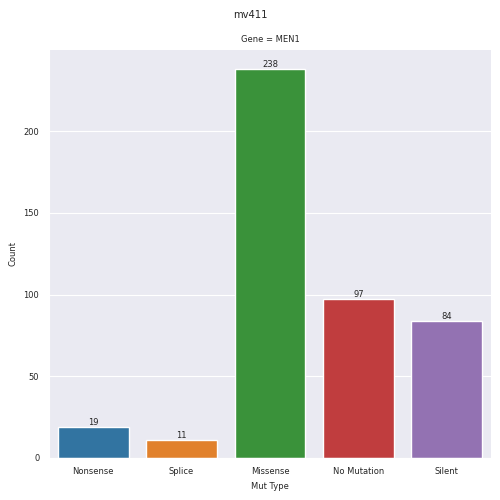

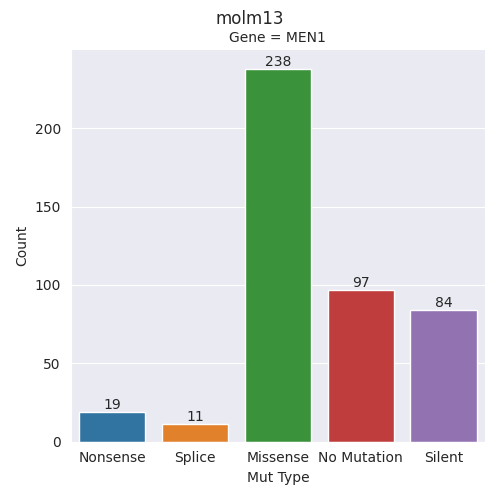

In [15]:
# @title QA Bar Plot
# display(SVG(f'/content/{output_dir}/hypothesis_qc/hypothesis2_scatterplot_by_screenid.svg'))
display(Image(filename=f'/content/{output_dir}/screendata/plots/mv411_barplot_by_muttype.png'))
display(Image(filename=f'/content/{output_dir}/screendata/plots/molm13_barplot_by_muttype.png'))


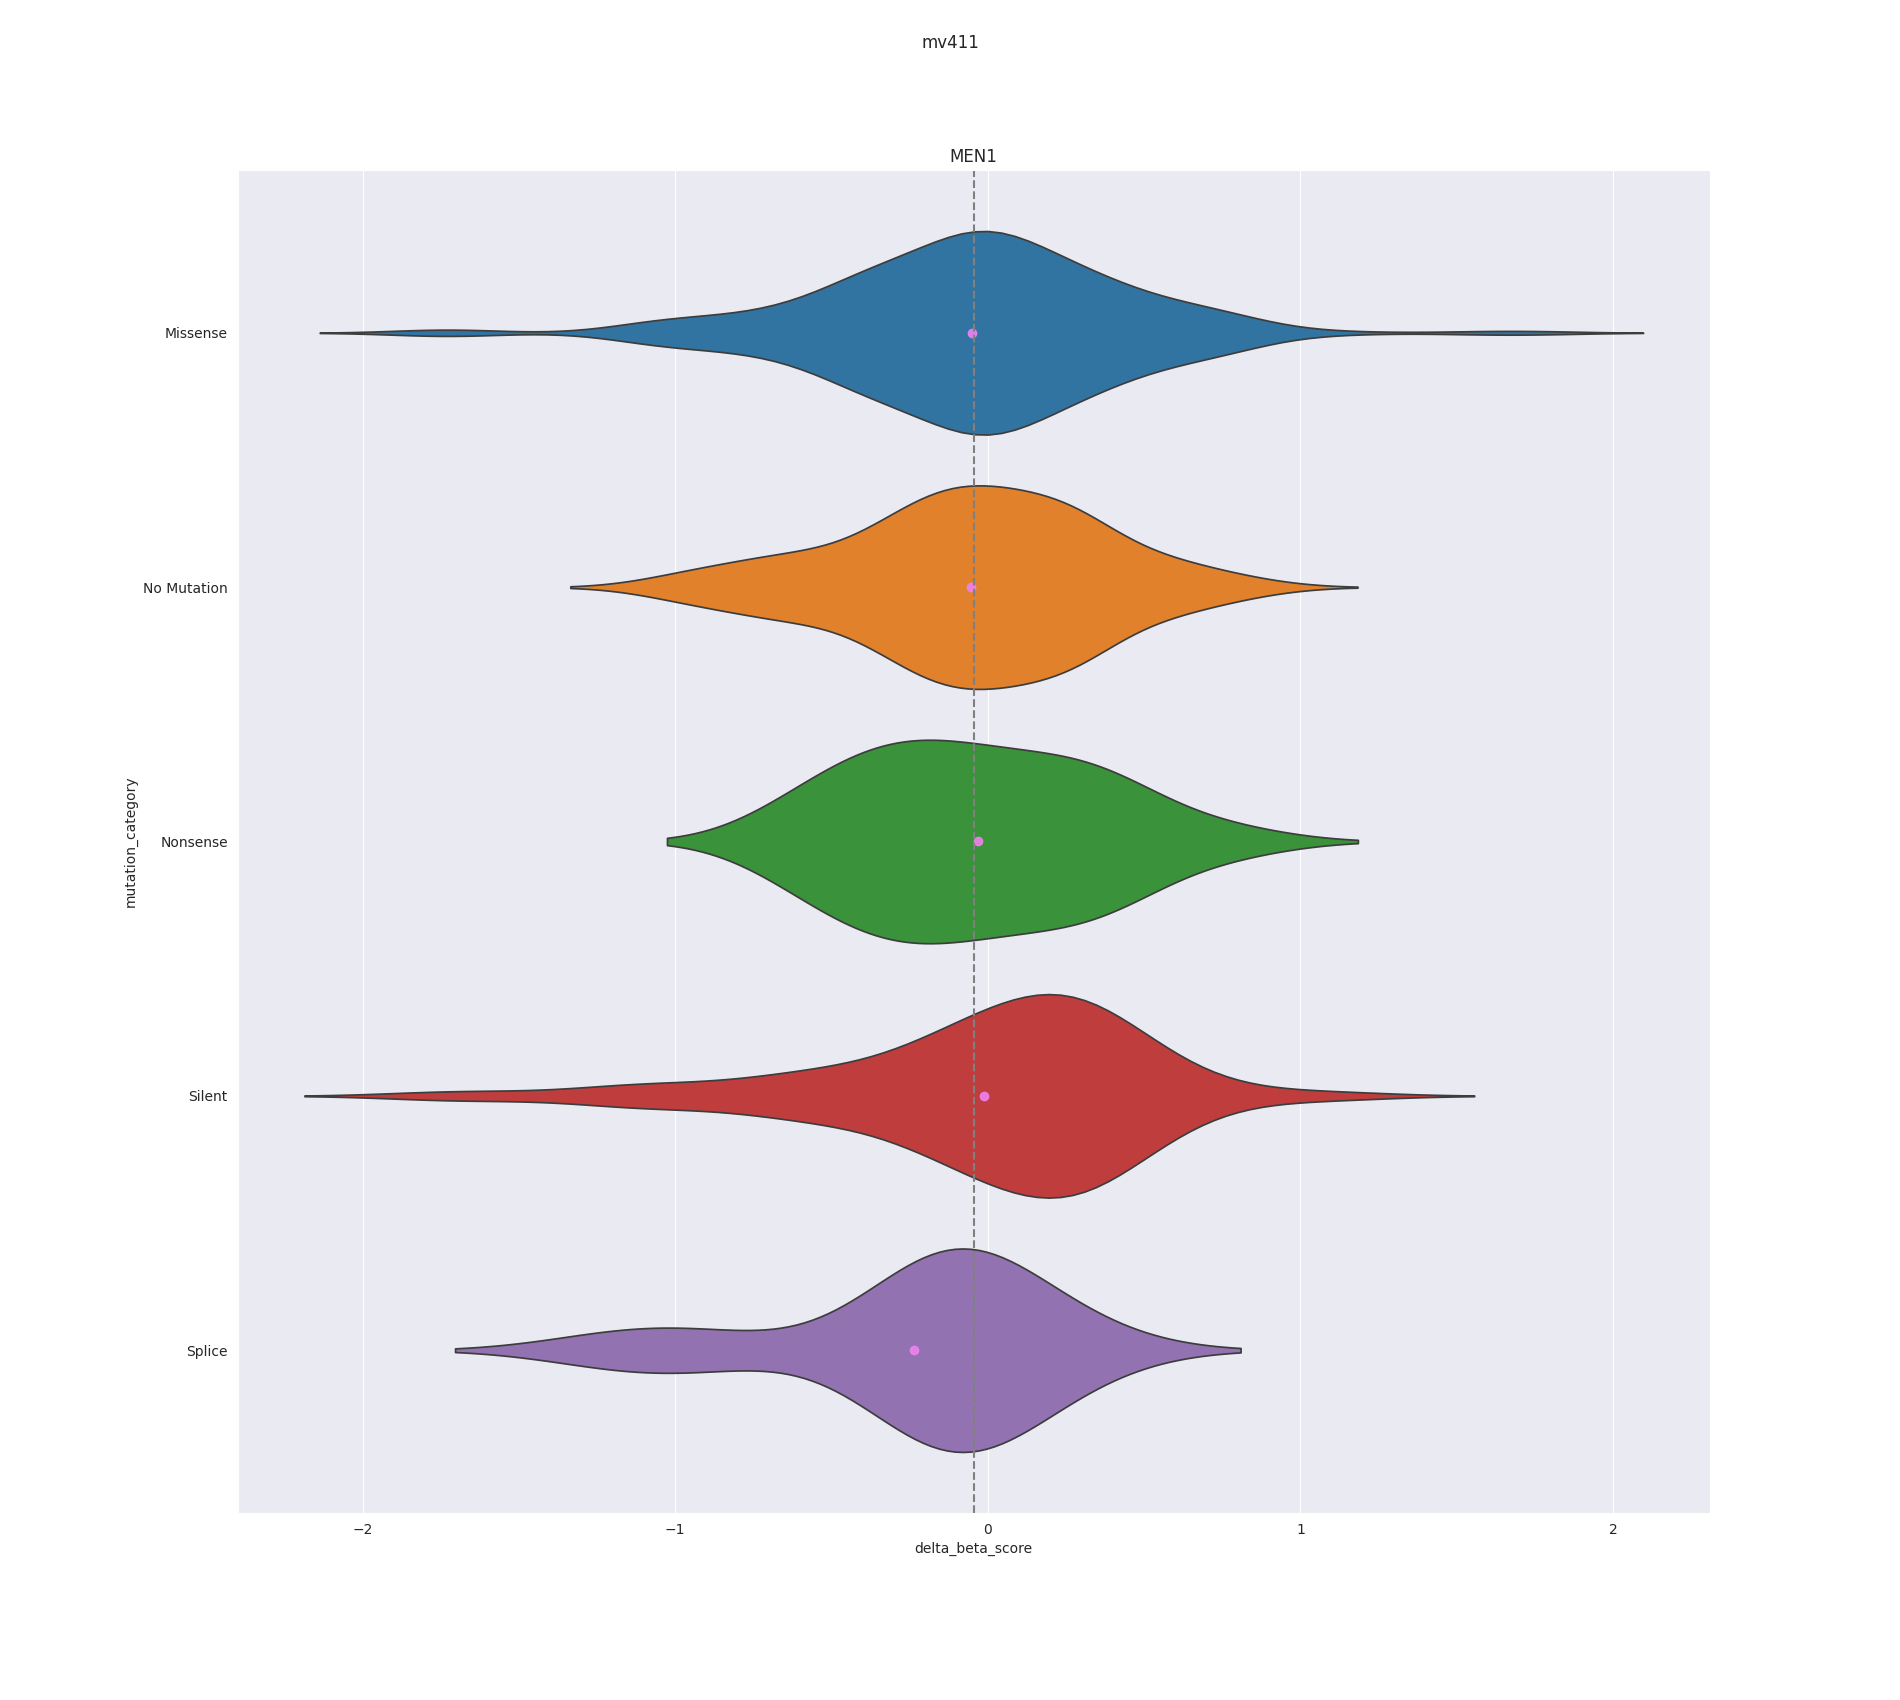

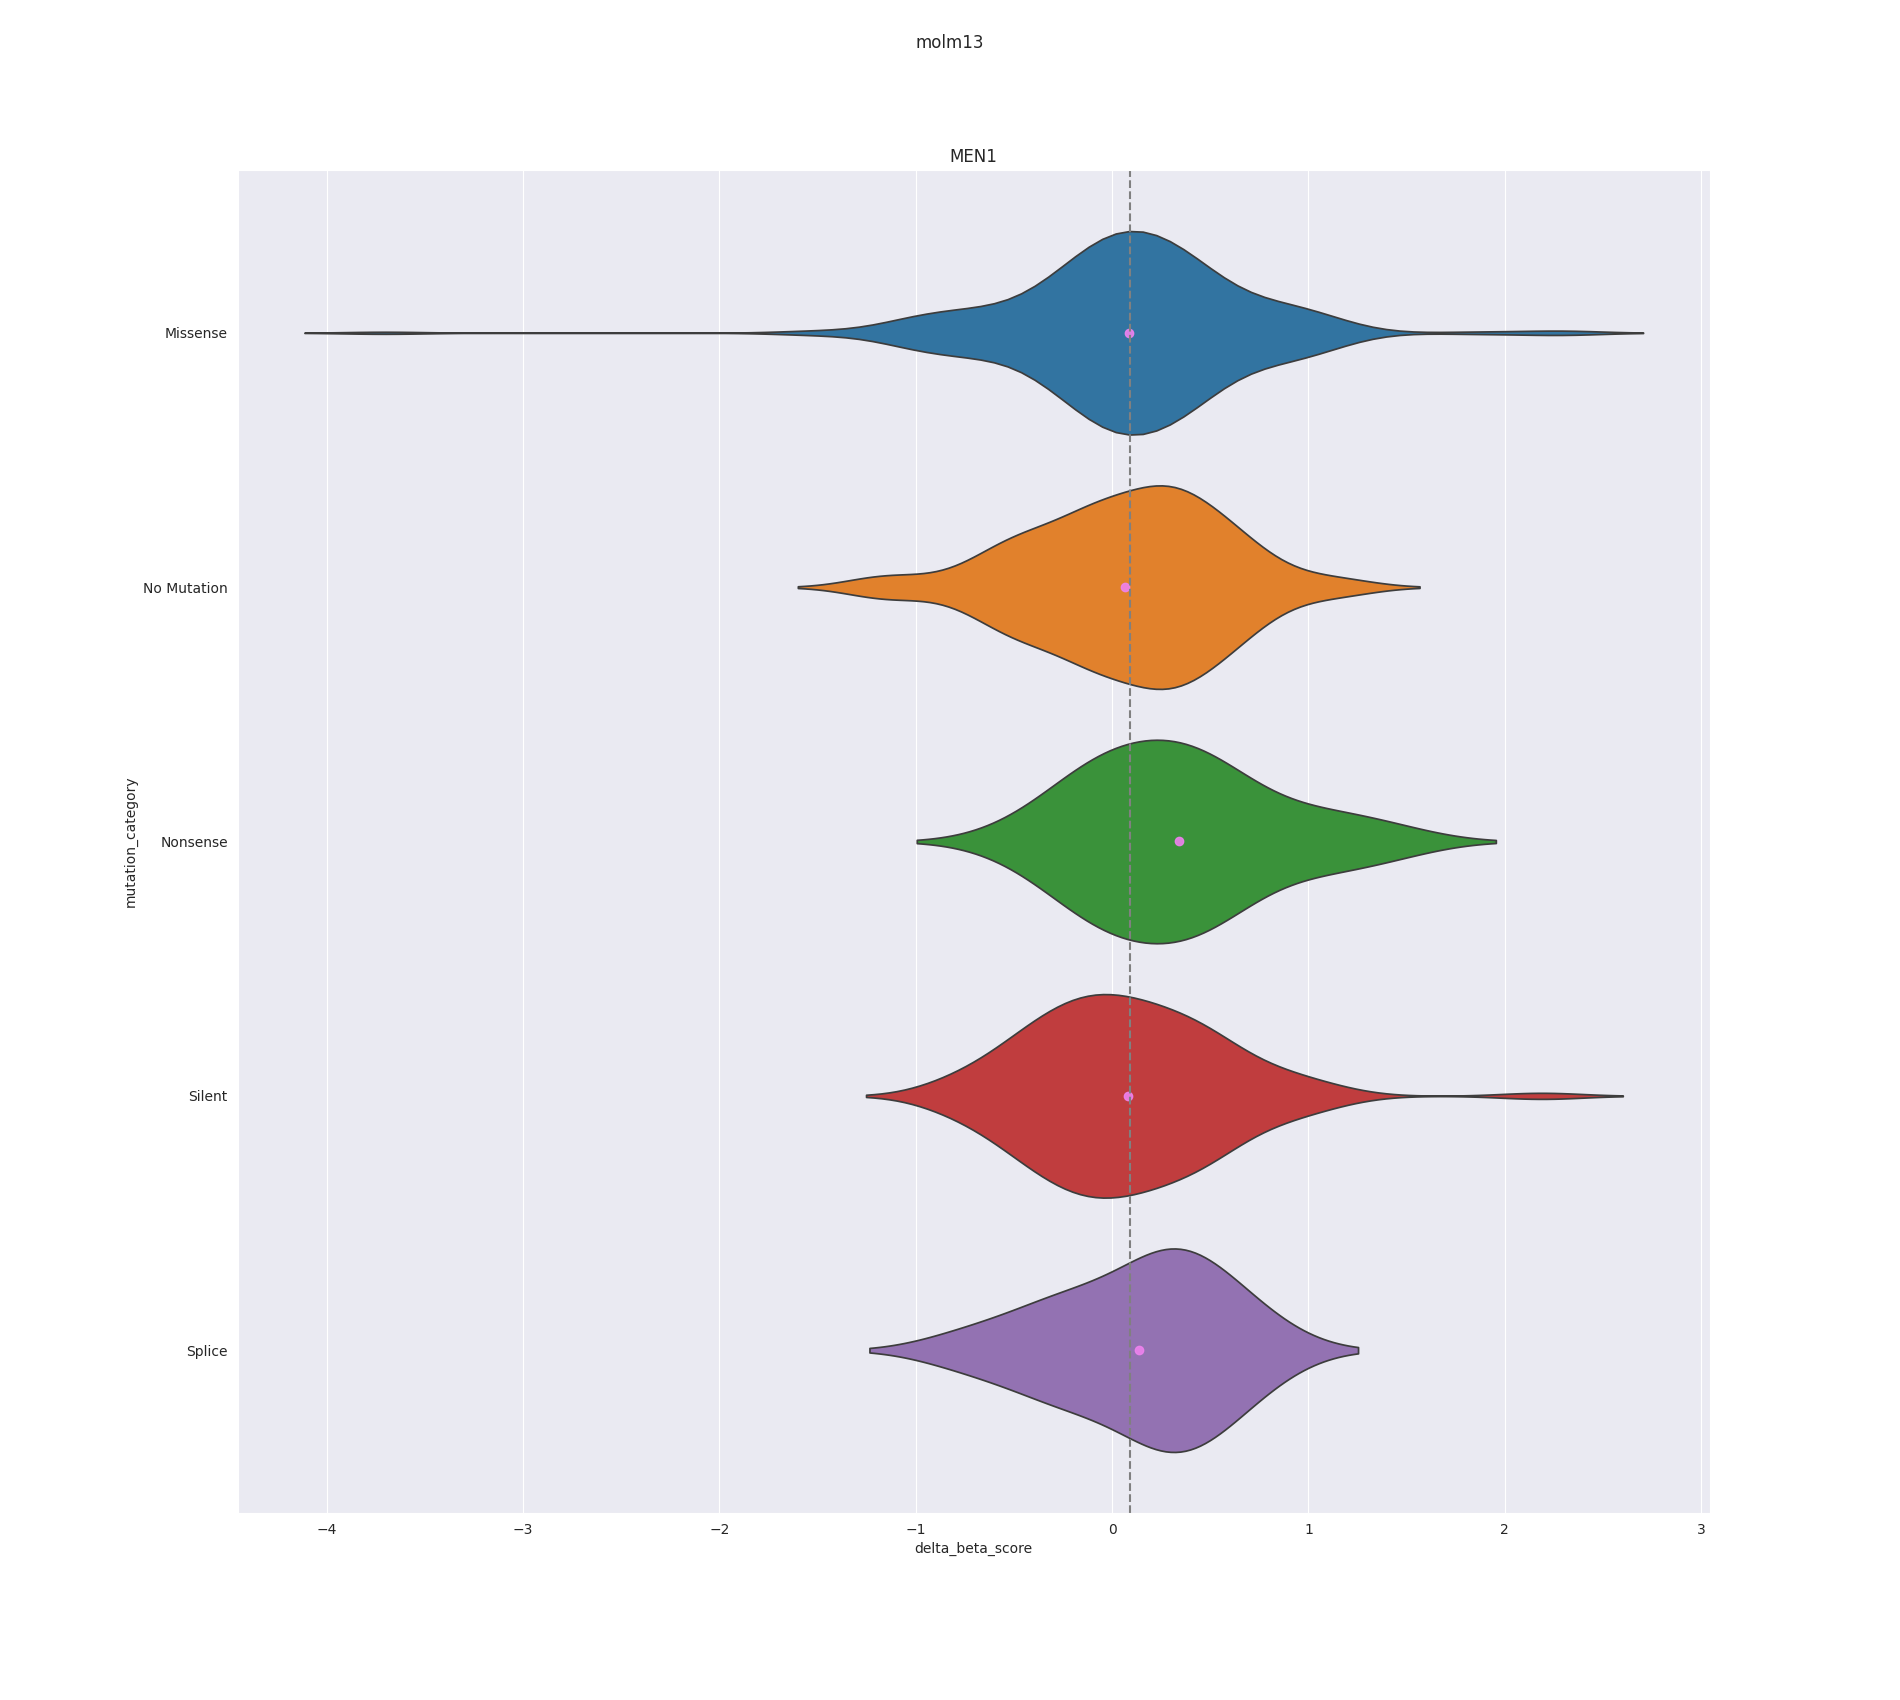

In [16]:
# @title QA Violin Plot
display(Image(filename=f'/content/{output_dir}/screendata/plots/mv411_violinplot_by_muttype.png'))
display(Image(filename=f'/content/{output_dir}/screendata/plots/molm13_violinplot_by_muttype.png'))

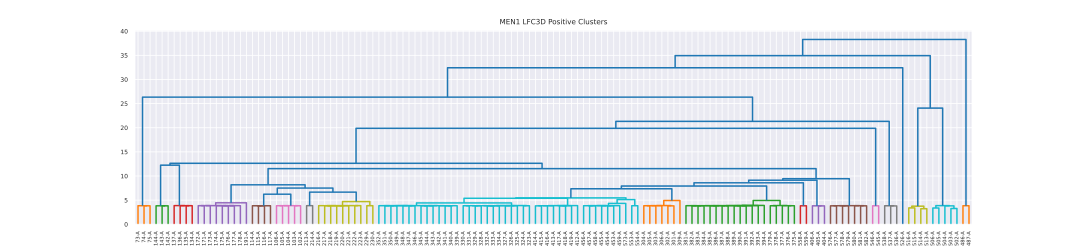

In [17]:
# @title LFC3D Hit Clusters (Dendrogram)
display(SVG(filename=f'/content/{output_dir}/cluster_LFC3D/plots/MEN1_Meta_LFC3D_Positive_Dendrogram_6A.svg'))